In [1]:
%load_ext autoreload
import json
import sys
import pathlib
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import random
from llm import send_prompt, sort_function
from sort import quicksort, heapsort

cp_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/corona_pandemie').rglob('*.ipynb'):
    with open(file) as f:
        cp_data[file.stem.removeprefix('corona_pandemie_')] = json.load(f)

cw_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/corona_warn_app_analyse').rglob('*.ipynb'):
    with open(file) as f:
        cw_data[file.stem.removeprefix('corona_warn_app_analyse_')] = json.load(f)

rp_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/reproduktionszahl').rglob('*.ipynb'):
    with open(file) as f:
        rp_data[file.stem.removeprefix('reproduktionszahl_')] = json.load(f)

wr_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/werbeindustrie').rglob('*.ipynb'):
    with open(file) as f:
        wr_data[file.stem.removeprefix('werbeindustrie_')] = json.load(f)

In [2]:
from copy import deepcopy

def filter_images(data):
    """Sets the image data to None in the output of code cells."""
    for k, v in data.items():
        for cell in v['cells']:
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                for output in cell['outputs']:
                    if 'data' in output and 'image/png' in output['data']:
                        # remove image from data
                        output['data']['image/png'] = None

filter_images(cp_data)
filter_images(cw_data)
filter_images(rp_data)
filter_images(wr_data)

def filter_output_cells(data_array):
    """Removes the output of code cells."""
    data = deepcopy(data_array)
    for k, v in data.items():
        for i, cell in enumerate(v['cells']):
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                #print(cell['outputs'])
                data[k]['cells'][i]['outputs'] = []
    return data

## Reproduktionszahlen

In [4]:
def sort_f1(d1, d2):
    systemprompt = """You are provided with two Jupyter notebooks, 'Notebook A' and 'Notebook B,' each containing exercises and their corresponding solutions. Your task is to evaluate which notebook provides the better solutions based on the following criteria: correctness, accuracy, and completeness. A correct solution should provide the intended answer without errors, an accurate solution should be precise and well-reasoned, and a complete solution should contain solutions to all exercises.

After evaluating both notebooks, output ONLY one of the following responses: 'Notebook A' or 'Notebook B.' Do not include any additional text—only return the name of the better notebook."""

    return sort_function(d1, d2, rp_data, systemprompt)

In [5]:
%autoreload 2
from sort import quicksort, heapsort
import random

check_idxs = list(rp_data.keys())
random.shuffle(check_idxs)

rp_data_sorted = heapsort(check_idxs, sort_f1)

<think>
Okay, I need to evaluate which notebook, A or B, provides better solutions based on correctness, accuracy, and completeness. Let me go through each notebook step by step.

Starting with Notebook A. In step (2), the user correctly imports the data and converts 'Meldedatum' to datetime, then sets it as the index. That's good. Moving to step (3), they calculate the 4-day rolling sums. Hmm, the code they used adds four shifted versions of the 'Deutschland' column. That might not be the right approach because it doesn't handle missing values or non-consecutive dates properly. Also, when calculating R0, they divide summen[3:-1] by summe[0:-4], but there's a typo—summe instead of summen. That could cause errors. 

Looking at the output, there are NaNs in the R0 series, which might be due to the incorrect calculation or missing data handling. The visualization in step (4) is a simple plot, but the axes and title are correctly set. In step (5), the user tried to find R0 values over 2 bu

In [7]:
rp_data_sorted

['fb4b',
 '8ac3',
 '066e',
 '9eb2',
 '146f',
 '63e1',
 '4ca2',
 'ad47',
 '21de',
 'a044',
 '44bd',
 '4c2a',
 '7cc7',
 'b56b',
 'c926',
 'abd2',
 '23a6',
 'c938',
 '6f62',
 '8eaf',
 '6c5b',
 '1953',
 'b14b',
 '8c43',
 'baa4',
 '6b4e',
 '88a6',
 'cb76',
 '2281',
 '8d45',
 '3669',
 'd28c',
 'eac9',
 'fe28',
 '4c41']

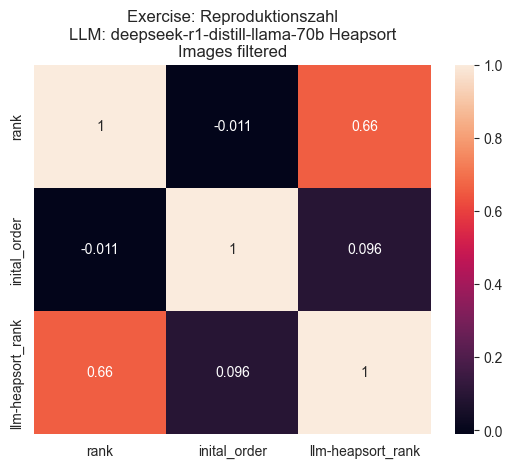

In [8]:
reproduktionszahl_points = pd.read_csv('data/shared-dataset/reproduktionszahl_points.csv')

df = reproduktionszahl_points.loc[:, ['id', 'rank']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: rp_data_sorted[::-1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Reproduktionszahl\nLLM: deepseek-r1-distill-llama-70b Heapsort\nImages filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [9]:
rp_data_filtered = filter_output_cells(rp_data)

In [10]:
%autoreload 2
from llm import send_prompt, sort_function

def sort_f2(d1, d2):
    systemprompt = """You are provided with two Jupyter notebooks, 'Notebook A' and 'Notebook B,' each containing exercises and their corresponding solutions. Your task is to evaluate which notebook provides the better solutions based on the following criteria: correctness, accuracy, and completeness. A correct solution should provide the intended answer without errors, an accurate solution should be precise and well-reasoned, and a complete solution should contain solutions to all exercises.

After evaluating both notebooks, output ONLY one of the following responses: 'Notebook A' or 'Notebook B.' Do not include any additional text—only return the name of the better notebook."""
    return sort_function(d1, d2, rp_data_filtered, systemprompt)

In [11]:
initial_ordering = list(rp_data_filtered.keys())
random.shuffle(initial_ordering)

rp_data_filtered_sorted = heapsort(initial_ordering, sort_f2)

<think>
Okay, I need to evaluate which notebook, A or B, provides better solutions based on correctness, accuracy, and completeness. Let me go through each notebook step by step.

Starting with Notebook A. The task is to calculate the reproduction number R0 for COVID-19 in Germany using data from the RKI. 

In step (2), the user imports the data and converts the 'Meldedatum' column to datetime, then sets it as the index. That seems correct. 

Moving to step (3), they calculate the rolling 4-day sum of infections using `rolling(4).sum()`, which aligns with the problem definition. Then, they compute R0 by dividing the current 4-day sum by the previous 4-day sum, shifted by 4 days. This approach correctly implements the formula provided. 

In step (4), they visualize R0 using `plot()`, set the title, and display the plot. This fulfills the visualization requirement with proper labels and title.

For step (5), they filter and print the dates where R0 exceeds 2. The solution correctly ident

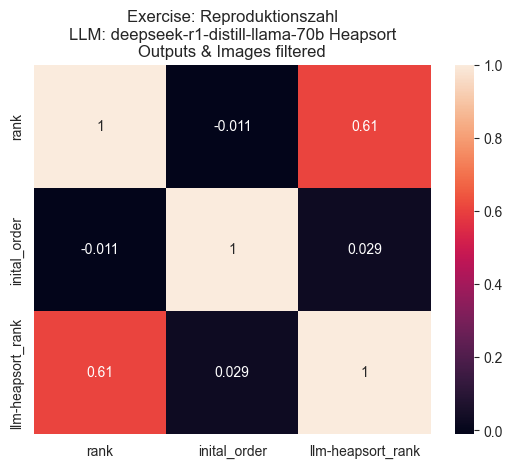

In [12]:
df = reproduktionszahl_points.loc[:, ['id', 'rank']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: rp_data_filtered_sorted[::-1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Reproduktionszahl\nLLM: deepseek-r1-distill-llama-70b Heapsort\nOutputs & Images filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [1]:
# convert jupyter notebook to markdown
import nbformat
from nbconvert import MarkdownExporter

def nb_to_md(nb):
    exporter = MarkdownExporter()
    markdown, _ = exporter.from_notebook_node(nbformat.from_dict(nb))
    return markdown

nb_to_md(nbformat.read('data/shared-dataset/corona_pandemie/corona_pandemie_4c41.ipynb', as_version=4))

'### Aufgabe: Corona-Pandemie\n\n\nIm Frühjahr 2020 begann sich das neuartiges Coronavirus SARS-CoV-2, welches die Lungenerkrankung Covid-19 verursachen kann, in Deutschland und Europa schlagartig zu verbreiten. In dieser Aufgabe analysieren und visualisieren Sie das Infektionsgeschehen in Deutschland.\n\n**Ihre Daten**\n\nEin vereinfachter Datensatz des Robert Koch Instituts (RKI) steht Ihnen in dieser Aufgabe zur Verfügung.\n\n**Ihre Aufgaben**\n\n(1) Führen Sie zunächst die unten stehende Code-Zelle aus, um den Datensatz und die Pandas-Bibliothek verfügbar zu machen.\n\n\n\n```python\nimport pandas as pd\n\n# Daten des Robert Koch Instituts\nRKI_data_simplified = \'http://lab.bialonski.de/data/ds/kUdBuPrXjvr5d640Ey3UN82VKz646KLj2tuZFTFZ.csv\'\n```\n\n(2) Importieren Sie mithilfe von Pandas den Datensatz in einen DataFrame, den Sie `df_covid` nennen. Nutzen Sie dazu die Variable `RKI_data_simplified`.\n\n\n\n```python\n# Ihr Code\n\ndf = pd.read_csv(RKI_data_simplified)\ndf.head()\n`

In [5]:
import json
nbf_4c41 = nbformat.read('data/shared-dataset/corona_pandemie/corona_pandemie_4c41.ipynb', as_version=4)

with open('data/shared-dataset/corona_pandemie/corona_pandemie_4c41.ipynb') as f:
    json_4c41 = json.load(f)

## Corona Warn App Analyse

In [6]:
def sort_f3(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, cw_data, systemprompt)

sort_f3('4c41', 'fb4b')

check_idxs = list(cw_data.keys())
random.shuffle(check_idxs)

cw_data_sorted = heapsort(check_idxs, sort_f3)

4c41 > fb4b
b14b > eac9
b14b > 4ca2
d28c > 2281
d28c > 8c43
21de > 8d45
21de < 7cc7
88a6 > a044
88a6 > 6f62
3669 > 6b4e
3669 > abd2
fb4b < baa4
baa4 > 23a6
8eaf > cb76
8eaf > 1953
8ac3 < 066e
066e < c938
c926 > b56b
c926 > ad47
d28c > b14b
8c43 < 2281
2281 > 44bd
88a6 > 7cc7
6f62 > a044
6f62 > 9eb2
baa4 > 3669
fb4b < 23a6
23a6 > 6c5b
c938 > 8eaf
8ac3 < 066e
066e > 146f
d28c > c926
2281 > b14b
8c43 < 44bd
44bd > 4c2a
baa4 > 88a6
23a6 > 3669
fb4b < 6c5b
6c5b < 4c41
23a6 > 4c41
d28c > c938
2281 > c926
44bd > b14b
8c43 < 4c2a
4c2a < fe28
44bd > fe28
d28c > baa4
Rate limit hit. Retrying in 20 seconds... (Attempt 1/10)
2281 > c938
44bd > c926
fe28 > b14b
8c43 < 4c2a
4c2a < 63e1
fe28 > 63e1
2281 > baa4
44bd < c938
066e < 8eaf
1953 > cb76
1953 > eac9
c938 > baa4
44bd > 8eaf
fe28 > c926
63e1 > b14b
8c43 < 4c2a
4c2a > 4ca2
44bd > baa4
fe28 > 8eaf
63e1 > c926
4c2a < b14b
b14b > 4ca2
fe28 > baa4
63e1 > 8eaf
b14b > c926
4c2a > 4ca2
4c2a > 8c43
63e1 > baa4
b14b > 8eaf
4c2a < c926
Rate limit hit. Ret

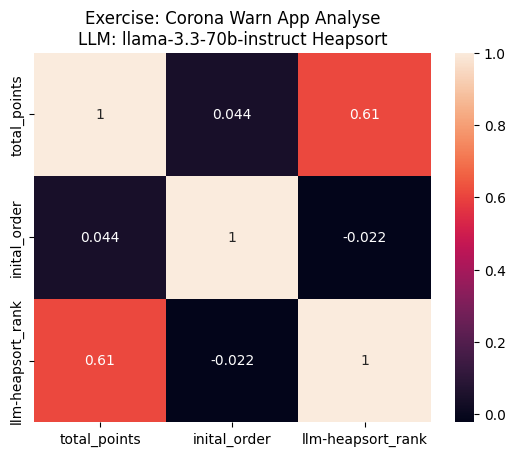

In [15]:
corona_warn_app_analyse_points = pd.read_csv('data/shared-dataset/corona_warn_app_analyse_points.csv')

df = corona_warn_app_analyse_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: cw_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Corona Warn App Analyse\nLLM: llama-3.3-70b-instruct Heapsort")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [18]:
from copy import deepcopy
def filter_output_cells(data_array):
    """Removes the output of code cells."""
    data = deepcopy(data_array)
    for k, v in data.items():
        for i, cell in enumerate(v['cells']):
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                #print(cell['outputs'])
                data[k]['cells'][i]['outputs'] = []
    return data

cw_data_filterd = filter_output_cells(cw_data)

def sort_f4(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, cw_data_filterd, systemprompt)

check_idxs = list(cw_data.keys())
random.shuffle(check_idxs)

cw_data_sorted = heapsort(check_idxs, sort_f4)

Rate limit hit. Retrying in 1351 seconds... (Attempt 1/10)
066e > 21de
066e < 8eaf
3669 > 63e1
3669 > 8c43
b14b > 23a6
b14b > 8ac3
b56b > 6c5b
b56b > 4c2a
c926 > baa4
c926 > 4c41
7cc7 > 6f62
7cc7 > abd2
146f < 44bd
44bd > 88a6
1953 > ad47
1953 > 9eb2
6b4e > 4ca2
6b4e < 2281
3669 > 8eaf
8c43 > 63e1
8c43 > a044
b56b < b14b
8ac3 < 23a6
23a6 > cb76
7cc7 > c926
abd2 < 6f62
6f62 > fb4b
1953 > 44bd
9eb2 < ad47
ad47 > 8d45
Rate limit hit. Retrying in 37 seconds... (Attempt 1/10)
3669 < 2281
6b4e > 4ca2
6b4e < c938
2281 > c938
7cc7 > b14b
6f62 < c926
4c41 > baa4
4c41 > d28c
2281 > 1953
3669 > c938
8c43 > 8eaf
a044 < 63e1
63e1 > eac9
2281 > 7cc7
3669 > 1953
8c43 < c938
6b4e > 4ca2
6b4e < fe28
c938 > fe28
3669 < 7cc7
c926 > b14b
6f62 < 4c41
d28c > baa4
d28c > 21de
3669 > c926
c938 > 1953
8c43 < fe28
6b4e > 4ca2
6b4e > 066e
c938 > c926
Rate limit hit. Retrying in 37 seconds... (Attempt 1/10)
fe28 > 1953
8c43 > 6b4e
63e1 > 8eaf
a044 < eac9
63e1 < eac9
8c43 < eac9
fe28 < eac9
c938 > eac9
eac9 > c926

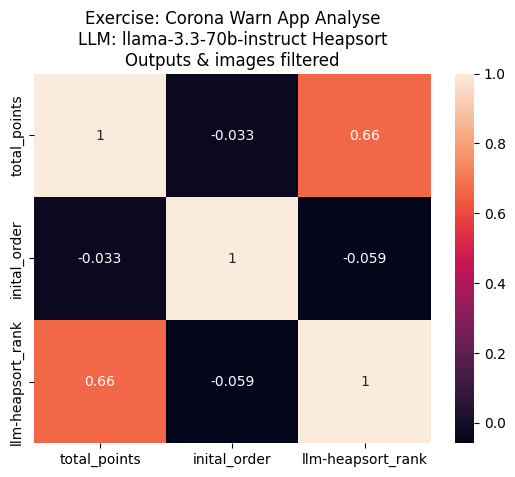

In [58]:
df = corona_warn_app_analyse_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: cw_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Corona Warn App Analyse\nLLM: llama-3.3-70b-instruct Heapsort\nOutputs & images filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [60]:
df.sort_values('llm-heapsort_rank')

,total_points,inital_order,llm-heapsort_rank
id,,,
fb4b,0,5,0
9eb2,0,9,1
146f,0,21,2
6c5b,2,28,3
8ac3,4,14,4
4ca2,10,18,5
8d45,9,4,6
abd2,9,11,7
066e,13,33,8


## Corona Pandemie

In [8]:
cp_data_filterd = filter_output_cells(cp_data)

def sort_f5(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, cp_data_filterd, systemprompt)

check_idxs = list(cp_data_filterd.keys())
random.shuffle(check_idxs)

cp_data_sorted = heapsort(check_idxs, sort_f5)

63e1 > 8c43
63e1 > ad47
Request timed out. Retrying in 2 seconds... (Attempt 1/10)
146f < d28c


KeyboardInterrupt: 

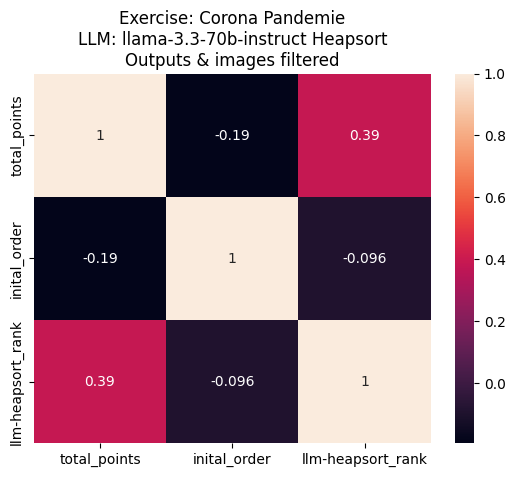

In [62]:
corona_pandemie_points = pd.read_csv('data/shared-dataset/corona_pandemie_points.csv')

df = corona_pandemie_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: cp_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Corona Pandemie\nLLM: llama-3.3-70b-instruct Heapsort\nOutputs & images filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [63]:
df.sort_values('llm-heapsort_rank')

,total_points,inital_order,llm-heapsort_rank
id,,,
8ac3,0,28,0
fb4b,5,35,1
146f,2,29,2
9eb2,11,22,4
066e,29,25,5
21de,25,3,6
6c5b,14,15,7
4c2a,35,20,8
ad47,35,26,9


In [22]:
%autoreload 2
from llm import send_prompt, sort_function
def sort_f6(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, cp_data, systemprompt)

check_idxs = list(cp_data.keys())
random.shuffle(check_idxs)

cp_data_sorted = heapsort(check_idxs, sort_f6)

<think>
Okay, I need to determine which notebook, A or B, has the better solutions based on the given criteria: correct, accurate, and complete. Let me go through each notebook step by step.

Starting with Notebook A, I see that in step (3), the user is instructed to convert the 'Meldedatum' column to datetime and set it as the index. The code provided is:

pd.to_datetime(df_covid.loc[:,'Meldedatum'])
pd.DataFrame.set_index(df_covid,'Meldedatum')

Hmm, wait a minute. The first line converts the 'Meldedatum' column to datetime but doesn't assign it back to the DataFrame. So, this line doesn't actually change the DataFrame. The second line uses pd.DataFrame.set_index, which is a static method, but it's not called correctly. It should be df_covid.set_index('Meldedatum'), not pd.DataFrame.set_index(df_covid, 'Meldedatum'). This means the index isn't being set properly, which could cause issues in subsequent steps.

Now looking at Notebook B, in the same step (3), the code is:

df_covid['Me

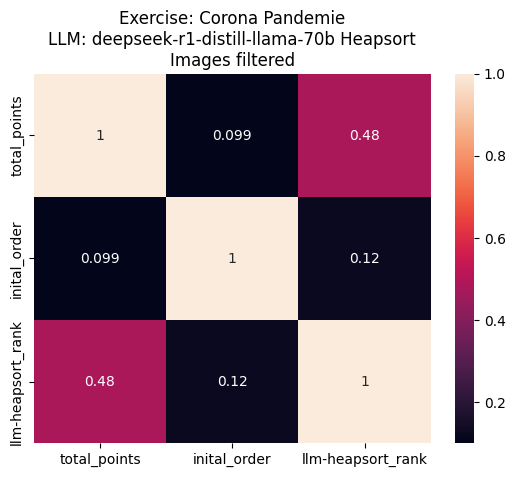

In [26]:
corona_pandemie_points = pd.read_csv('data/shared-dataset/corona_pandemie_points.csv')

df = corona_pandemie_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: cp_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Corona Pandemie\nLLM: deepseek-r1-distill-llama-70b Heapsort\nImages filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [29]:
df.sort_values('llm-heapsort_rank')

,total_points,inital_order,llm-heapsort_rank
id,,,
8ac3,0,1,0
6c5b,14,4,1
9eb2,11,5,2
fb4b,5,25,3
146f,2,33,4
88a6,35,2,5
21de,25,18,6
4ca2,31,20,7
3669,36,26,8
